In [1]:
pip install pillow


Note: you may need to restart the kernel to use updated packages.


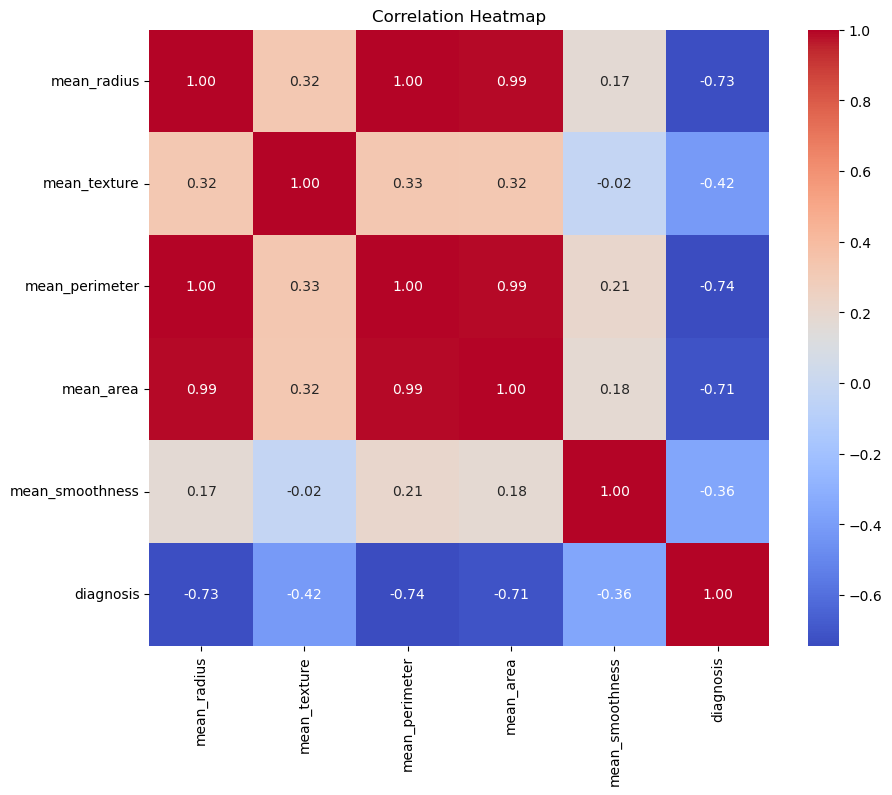

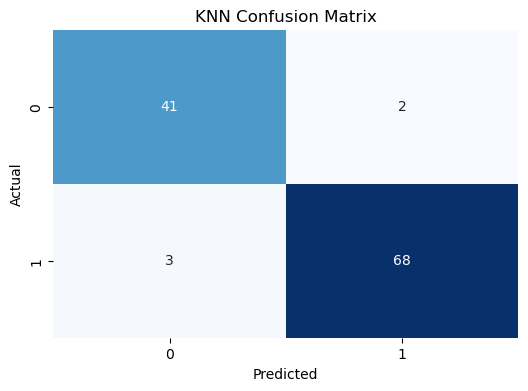

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageOps
import numpy as np

# Load and preprocess data functions
def load_data():
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    if not file_path:
        return None
    data = pd.read_csv(file_path)
    messagebox.showinfo("Info", "Data Loaded Successfully!")
    return data

def preprocess_data(data):
    X = data.drop('diagnosis', axis=1)
    y = data['diagnosis']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Plotting functions
def visualize_data(data):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Model training and evaluation
def train_and_evaluate(model_name, X_train, X_test, y_train, y_test):
    global trained_model
    if model_name == "KNN":
        model = KNeighborsClassifier(n_neighbors=8)
    elif model_name == "Random Forest":
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == "SVM":
        model = SVC(kernel='linear', probability=True, random_state=42)
    else:
        messagebox.showerror("Error", "Unknown Model Selected!")
        return
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(cm, f"{model_name} Confusion Matrix")
    
    report = classification_report(y_test, y_pred)
    messagebox.showinfo(f"{model_name} Accuracy", f"Accuracy: {accuracy:.4f}\n\n{report}")
    
    # Store the trained model and scaler for later use
    trained_model = model
    global scaler
    scaler = StandardScaler()
    scaler.fit(X_train)

# Image preprocessing function
def preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        image = ImageOps.fit(image, (1, 5), Image.LANCZOS)  # Resize to 1x5 to match 5 features
        image = np.array(image)
        image = image.flatten()  # Flatten to 1D array
        image = scaler.transform([image])  # Scale using the same scaler as training data
        return image
    except Exception as e:
        messagebox.showerror("Error", f"Failed to preprocess image:\n{e}")
        return None

# Image prediction function
def upload_and_predict():
    if loaded_data is None:
        messagebox.showwarning("Warning", "Please load and train the model first!")
        return
    if trained_model is None:
        messagebox.showwarning("Warning", "Please train the model first!")
        return
    
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.png;*.jpg;*.jpeg;*.bmp")])
    if not file_path:
        return
    
    processed_image = preprocess_image(file_path)
    if processed_image is not None:
        try:
            prediction = trained_model.predict(processed_image)
            proba = trained_model.predict_proba(processed_image)
            diagnosis = prediction[0]
            probability = np.max(proba) * 100
            messagebox.showinfo("Prediction Result", f"Diagnosis: {diagnosis}\nProbability: {probability:.2f}%")
        except AttributeError:
            # Some models like SVM may not have predict_proba
            prediction = trained_model.predict(processed_image)
            diagnosis = prediction[0]
            messagebox.showinfo("Prediction Result", f"Diagnosis: {diagnosis}")
        except Exception as e:
            messagebox.showerror("Error", f"Prediction failed:\n{e}")

# GUI functions
def select_file():
    data = load_data()
    if data is not None:
        global loaded_data
        loaded_data = data

def visualize():
    if loaded_data is not None:
        visualize_data(loaded_data)
    else:
        messagebox.showwarning("Warning", "Please load the data first!")

def run_model():
    if loaded_data is not None:
        X_train, X_test, y_train, y_test, _ = preprocess_data(loaded_data)
        selected_model = model_var.get()
        train_and_evaluate(selected_model, X_train, X_test, y_train, y_test)
    else:
        messagebox.showwarning("Warning", "Please load the data first!")

# Initialize global variables
loaded_data = None
trained_model = None
scaler = None

# Create GUI using Tkinter
root = tk.Tk()
root.title("Breast Cancer Classification")
root.geometry("500x400")

# Heading label
tk.Label(root, text="Breast Cancer Classifier", font=("Arial", 16)).pack(pady=10)

# Load data button
load_button = tk.Button(root, text="Load CSV Data", command=select_file, bg="lightblue", width=25)
load_button.pack(pady=10)

# Visualization button
visualize_button = tk.Button(root, text="Visualize Data", command=visualize, bg="lightgreen", width=25)
visualize_button.pack(pady=10)

# Model selection radio buttons
model_var = tk.StringVar(value="KNN")
tk.Label(root, text="Choose Model", font=("Arial", 12)).pack(pady=10)
tk.Radiobutton(root, text="KNN", variable=model_var, value="KNN").pack(anchor=tk.W, padx=20)
tk.Radiobutton(root, text="Random Forest", variable=model_var, value="Random Forest").pack(anchor=tk.W, padx=20)
tk.Radiobutton(root, text="SVM", variable=model_var, value="SVM").pack(anchor=tk.W, padx=20)

# Run model button
run_button = tk.Button(root, text="Run Model", command=run_model, bg="orange", width=25)
run_button.pack(pady=20)

# Add separator
separator = tk.Frame(root, height=2, bd=1, relief=tk.SUNKEN)
separator.pack(fill=tk.X, padx=5, pady=5)

# Image upload button
upload_button = tk.Button(root, text="Upload Image for Prediction", command=upload_and_predict, bg="lightyellow", width=25)
upload_button.pack(pady=10)

# Start the Tkinter event loop
root.mainloop()
